# Parse Electoral Rolls, 2022


## Workflow

The final electoral rolls for the 2022 BBMP elections were uploaded on the website http://knowyourbooth.in/ in a large number of PDF files. With this notebook, we want to explore parsing these PDF files to convert them into easy to search and manage CSV files. Below are the steps in the workflow:

### Step 1. List electoral rolls

On the page http://knowyourbooth.in/Final use the filters for District, Assembly and Ward to get electoral rolls for all part numbers in a ward. The image below lists all the electoral rolls in ward __240 Vinayakanagar__.

![](./images/step_1_list_electoral_rolls.png)

### Step 2. Download an electoral roll

Post clicking on the required electoral roll, the page reloads with a Captcha which needs to be filled post which cllicking on the __Click to View PDF__ will download the electoral rolls for the part number of choice as a PDF file.

![](./images/step_2_download_an_electoral_roll.png)

### Step 3. View electoral roll

Below is how the first page looks like with the actual electoral rolls on subsequent pages.

![](./images/step_3_view_electoral_roll.png)

From a structure of the dataset point of view, the hierarcy is below. Which means, one way to name the downloaded electoral rolls is in a simular format to reflect this structure, `ac75_w240_pn1.pdf`
1. Assembly constituency: 75
2. Ward: 240
3. Part number: 1

![](./images/electoral_rolls_structure.png)


## Dependencies

- [poppler/poppler](https://gitlab.freedesktop.org/poppler/poppler): Rendering PDF files and examining or modifying their structure.
- [Belval/pdf2image](https://github.com/Belval/pdf2image): Convert PDF to a PIL Image object.
- [madmaze/pytesseract](https://github.com/madmaze/pytesseract): Optical character recognition (OCR) tool.

In [ ]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
from pdf2image import convert_from_path
from pytesseract import pytesseract

from tqdm.notebook import tqdm

In [ ]:
# Read one of the PDF files with electoral rolls.
electoral_rolls = convert_from_path('./pdfs/ac151_w90_pn1.pdf', dpi=500, fmt='jpg')
print('Number of pages in the PDF: {}'.format(len(electoral_rolls)))

Number of pages in the PDF: 62


In [ ]:
def clean_image(image):
    """Clean an image for better OCR detection.
    
    Ref: https://tesseract-ocr.github.io/tessdoc/ImproveQuality.html
    """
    
    # Counter the images into a numpy array.
    pixels = np.array(image)
    
    # Binarization of the pixels to improve OCR detection.
    threshold = 120
    pixels[pixels > threshold] = 255 # Set all pixels greater than the threshold to white.
    pixels[pixels < threshold] = 0 # Set all pixels less than the threshold to black.

    return pixels

# Cleanup the image and extra text from the image using Tesseract.
text = pytesseract.image_to_string(clean_image(electoral_rolls[2]))
print(text[:250])

Assembly Constituency No and Name : 175-Bommanahalli

Section No and Name : 1-Soma Sundara Palya.

UHN7876014
Name. YP SUMITHRA
Husband's Name. VASANTHAMURTHY
MC
House Number 11. NEAR SAI PURVA
APTS
Age: 48 Gender. FEMALE

Photo is
Available

UHN3033


## Structured PDF

OCR detection on the PDF file is able to extract the voter details like name, gender, etc but not the EPIC number, the primary challenge being the __underline below the EPIC number__. One solution to this problem is to cleanup the area around the EPIC number with appropriate padding so that OCR detection is done in a low-noise environment.

| Input | Image | OCR detection | Correct (Yes/No) | 
| --- | --- | --- | --- |
| Raw | ![](./images/epic_input_raw.png) | 7 | ❌ |
| Cropped + Padded | ![](./images/epic_input_cropped_and_padded.png) | WaJES58865 | ❌ |
| Manual review | - | __UZJ6358865__ | ✅ |
| Online tool | Upload `after.png` on https://www.imagetotext.info/ | UZJ6358865 | ✅ |

NOTE: The OCR after the crop + pad step is not right, but it's significantly better when compared to the detection on the raw image.

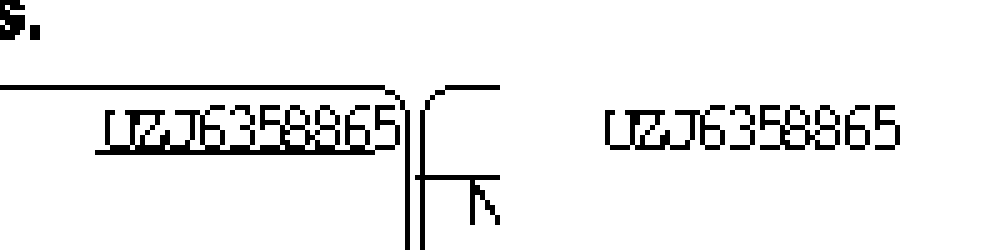

In [ ]:
def crop_image(image, original=False):
    """Crop image to work with parts of a large image.
    
    WIP: Only one voter details are currently cropped and returned.
    """
    
    # The amount of padding around the EPIC number.
    padding = 100
    
    # Convert the image into a numpy array.
    pixels = np.array(image)
    
    # Return the original image without the careful cropping and padding.
    if original:
        cropped_image = pixels[490-padding:540+padding, 1060-padding:1360+padding, :]
        return cropped_image
    
    # Step 1. Extract the exact location of the EPIC number.
    cropped_image = pixels[490:540, 1060:1360, :]
    
    # Step 2. Add extra padding on the top and bottom.
    cropped_image = np.concatenate([
        pixels[:padding, 1060:1360, :],
        cropped_image,
        pixels[:padding, 1060:1360, :]
    ], axis=0)
    
    # Step 3. Add extra padding on the left and right.
    cropped_image = np.concatenate([
        pixels[:cropped_image.shape[0], :padding, :],
        cropped_image,
        pixels[:cropped_image.shape[0], :padding, :]
    ], axis=1)
    
    return cropped_image

# Get the cropped image in the original form.
image_before = Image.fromarray(crop_image(clean_image(electoral_rolls[2]), original=True))
image_before.save(Path(Path.home(), 'Desktop/before.png'))

# Get the cropped image in the cleaned up form.
image_after = Image.fromarray(crop_image(clean_image(electoral_rolls[2]), original=False))
image_after.save(Path(Path.home(), 'Desktop/after.png'))

# Combine the two images into one image for top-down comparison with a border for understanding.
image = Image.fromarray(np.concatenate([np.array(image_before), np.array(image_after)], axis=1))
image

In [ ]:
# What are the OCR extracts for the two images, before and after! 🎉
print('{}, {}'.format(
    pytesseract.image_to_string(clean_image(image_before)).strip(),
    pytesseract.image_to_string(clean_image(image_after)).strip()
))

7, WaJES58865


## Extract EPIC numbers

In [ ]:
# Read PDF file with voter details and print the number pages.
directory = Path('./pdfs/')
filename = Path(directory, 'ceo_karnataka', 'chinmaya_218.pdf')

electoral_roll_images = convert_from_path(str(filename), dpi=500, fmt='jpg')
print('Number of pages in PDF: {}'.format(len(electoral_roll_images)))

Number of pages in PDF: 40


In [ ]:
epics = []
for electoral_roll_image in tqdm(electoral_roll_images):
    
    # Extract all detectable text on the page.
    electoral_roll_text = pytesseract.image_to_string(clean_image(electoral_roll_image))
    
    # Using regular expression, extract all EPIC numbers and append to list.
    # The assumption here is that all EPIC numbers being 3 characters and end with 7 numbers.
    epics += re.findall(r'[A-Z]{3}[0-9]{7}', electoral_roll_text)

# Convert from a list to a Pandas DataFrame and drop the duplicates.
epics = pd.DataFrame({'epic': epics}).drop_duplicates().reset_index(drop=True)

print(epics.shape)
epics.head()

  0%|          | 0/40 [00:00<?, ?it/s]

(946, 1)


,epic
0,UHN6188072
1,UHN6882559
2,UHN6882500
3,UHN6882542
4,UHN5666482


In [ ]:
# Write as CSV into the output directory.
output_directory = Path('./csvs/')
filename = Path(output_directory, 'ceo_karnataka', 'chinmaya_218.csv')
epics.to_csv(filename, index=False)